In [2]:
from __future__ import division

import logging

import cv2
import numpy as np
from numpy.lib.stride_tricks import as_strided
import scipy.sparse
import scipy.sparse.linalg

In [4]:
def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)

In [19]:
def compute_laplacian(img, mask=None, eps=10**(-7), win_rad=1):
    """Computes Matting Laplacian for a given image.
    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))
    print(win_inds.shape)
    
    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(np.bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    print(win_inds.shape)
    print(win_inds)
    winI = ravelImg[win_inds]
    print(winI.shape)
    
    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)
    print(win_mu.shape, win_var.shape)

    inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3))

    X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv)
    print(X.shape)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu))

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
    return L

In [20]:
img = np.random.rand(3, 3, 3)

In [21]:
compute_laplacian(img)

(1, 1, 3, 3)
(1, 9)
[[0 1 2 3 4 5 6 7 8]]
(1, 9, 3)
(1, 1, 3) (1, 3, 3)
(1, 9, 3)


<9x9 sparse matrix of type '<class 'numpy.float64'>'
	with 81 stored elements in COOrdinate format>

In [1]:
import cv2

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
img = cv2.imread('./scribble.png')

In [ ]:
img[np.where(img < 127)] = 0
img[np.where(img >= 127)] = 255

In [26]:
img[np.where((img == [255,255,255]).all(axis = 2))] = [0, 0, 0]

In [30]:
x[np.where((img == [255,255,255]).all(axis = 2))] = [1,1]

ValueError: shape mismatch: value array of shape (2,) could not be broadcast to indexing result of shape (0,)

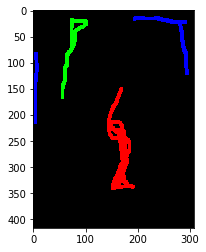

In [27]:
plt.imshow(img)
plt.show()

In [34]:
L = 3

prior = 0.33*np.ones([img.shape[0], img.shape[1], L])
prior[np.where((img == [255,0,0]).all(axis = 2))] = [1,0,0]
prior[np.where((img == [0,255,0]).all(axis = 2))] = [0,1,0]
prior[np.where((img == [0,0,255]).all(axis = 2))] = [0,0,1]


consts_map = np.zeros



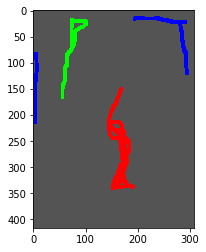

In [35]:
plt.imshow(prior)
plt.show()